In [1]:
# DGL Tutorial - follow up DGL at a Glance

In [2]:
# import modules
import dgl
from dgl.nn.pytorch import GraphConv
from dgl.data import citation_graph
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import networkx as nx
import itertools
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

Using backend: pytorch


In [3]:
# Step 1 : Creating a graph in DGL
def build_karate_club_graph() :

    path = "./example_graphs/karate.adjlist"
    with open(path, "r") as f :
        lines = f.readlines()
        src = []
        dst = []
        for line in lines :
            line = list(map(lambda x : int(x)-1, line.strip().split(" ")))
            for i in range(len(line)-1) :
                src.append(line[0])
                dst.append(line[i+1])
    src = np.array(src)
    dst = np.array(dst)
    u = np.concatenate([src, dst]) # from nodes
    v = np.concatenate([dst, src]) # to nodes
    
    return dgl.DGLGraph((u, v))

# G = build_karate_club_graph()
# num_nodes = G.number_of_nodes()
# num_edges = G.number_of_edges()
# print(G)
# print(f"number of nodes : {num_nodes}")
# print(f"number of edges : {num_edges}")

# nx_G = G.to_networkx().to_undirected()
# pos = nx.kamada_kawai_layout(nx_G)
# nx.draw(nx_G, pos, node_color=[[.7,.7,.7]])

def load_cora_data() :
    data = citation_graph.load_cora()
    features = torch.FloatTensor(data.features)
    labels = torch.LongTensor(data.labels)
    mask = torch.BoolTensor(data.train_mask)
    g = dgl.DGLGraph(data.graph)

    return g, features, labels, mask
g, features, labels, mask = load_cora_data()

In [4]:
# Step 2 : Assign Features
# embed = nn.Embedding(num_nodes, 5)
# G.ndata["feat"] = embed.weight
# print(G)

In [5]:
# Step 3 : Define a Graph Convolutional Network
class GCN(nn.Module) :
    def __init__(self, input_dim, output_dim, hidden_dim) :
        super(GCN, self).__init__()

        self.conv1 = GraphConv(input_dim, hidden_dim)
        self.conv2 = GraphConv(hidden_dim, output_dim)
        self.activ = nn.ReLU()

    def forward(self, g, inputs) :
        h = self.conv1(g, inputs)
        h = self.activ(h)
        h = self.conv2(g, h)
        return h

net = GCN(input_dim=features.shape[1], output_dim=7, hidden_dim=8)
print(net)

GCN(
  (conv1): GraphConv(in=1433, out=8, normalization=both, activation=None)
  (conv2): GraphConv(in=8, out=7, normalization=both, activation=None)
  (activ): ReLU()
)


In [6]:
# Step 4 : Data Preparation and Initialization
# inputs = embed.weight
# labeled_nodes = torch.tensor([0, num_nodes-1])
# labels = torch.tensor([0, 1])

In [10]:
# Step 5 : Train and Visualize
optimizer = optim.Adam(net.parameters(), lr=0.01)
all_logits = []
for epoch in range(50) :
    logits = net(g, features)
    all_logits.append(logits.detach().numpy())
    logp = F.log_softmax(logits, dim=-1)
    loss = F.nll_loss(logp[mask], labels[mask])

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(f"Episode : {epoch+1}, Loss : {loss.item()}")

Episode : 1, Loss : 1.9454929828643799
Episode : 2, Loss : 1.9331754446029663
Episode : 3, Loss : 1.919954776763916
Episode : 4, Loss : 1.9054728746414185
Episode : 5, Loss : 1.8902190923690796
Episode : 6, Loss : 1.875031590461731
Episode : 7, Loss : 1.8601676225662231
Episode : 8, Loss : 1.845431923866272
Episode : 9, Loss : 1.8306587934494019
Episode : 10, Loss : 1.8157532215118408
Episode : 11, Loss : 1.8011126518249512
Episode : 12, Loss : 1.78714120388031
Episode : 13, Loss : 1.7736594676971436
Episode : 14, Loss : 1.7603329420089722
Episode : 15, Loss : 1.7471274137496948
Episode : 16, Loss : 1.7340649366378784
Episode : 17, Loss : 1.7211729288101196
Episode : 18, Loss : 1.70833158493042
Episode : 19, Loss : 1.6954630613327026
Episode : 20, Loss : 1.682399868965149
Episode : 21, Loss : 1.669044017791748
Episode : 22, Loss : 1.655367374420166
Episode : 23, Loss : 1.641391396522522
Episode : 24, Loss : 1.627172827720642
Episode : 25, Loss : 1.6126298904418945
Episode : 26, Loss : 

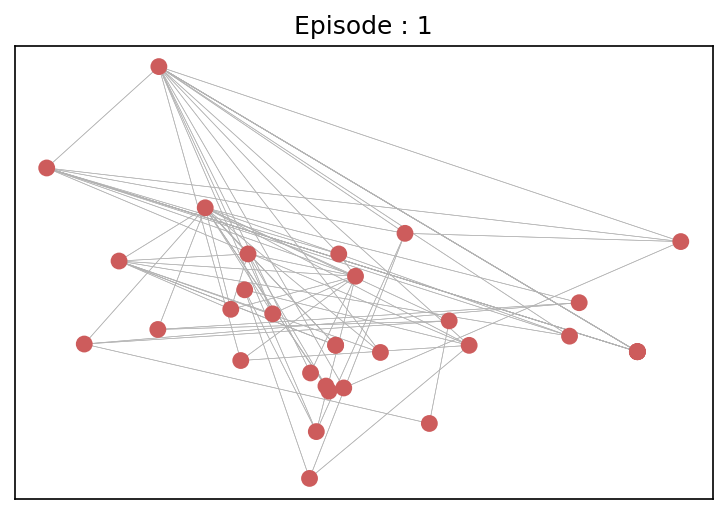

In [8]:
def draw(i) :
    cl_list = ["mediumpurple", "indianred"]
    position = []
    color = []
    
    for node in range(num_nodes) :
        position.append(all_logits[i][node])
        color.append(cl_list[np.argmax(position[-1])])
    
    ax.set_title(f"Episode : {i+1}")
    nx.draw_networkx(nx_G.to_undirected(), position, with_labels=False, node_color=color, node_size = 50, ax=ax, width=0.3, edge_color=[[.7,.7,.7]])

fig = plt.figure(dpi=150)
fig.clf()
ax = fig.subplots()
draw(0)

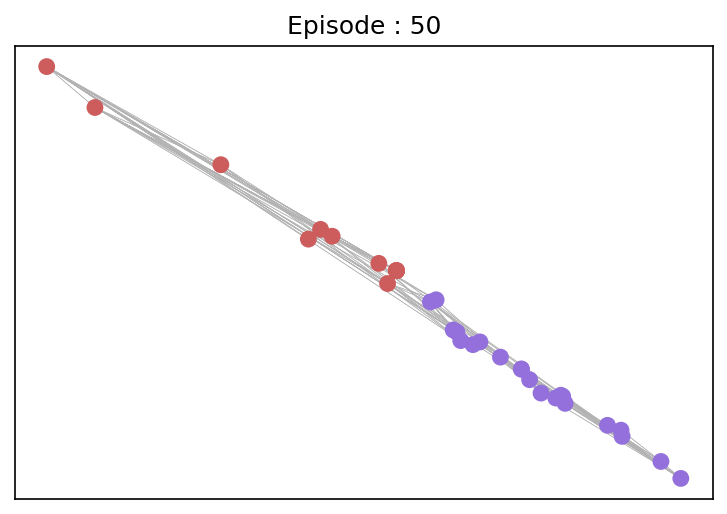

In [13]:
fig = plt.figure(dpi=150)
fig.clf()
ax = fig.subplots()
draw(49)

In [10]:
ani = animation.FuncAnimation(fig, draw, frames=len(all_logits), interval=200)
Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)
ani.save('training.mp4', writer=writer)

RuntimeError: Requested MovieWriter (ffmpeg) not available